In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn 

In [7]:
#Read main data to DataFrame
df = pd.read_stata('Cash_and_Childhood_Development_Replication/macoursetal_main.dta')  

In [8]:
# "hogarid_old","cp_old","unique_05", "cpmom_06" seran usats com a index
df_out=df[["a5sscore_i_06","a6smemory_p1_06","a6smemory_p2_06","a7a_delay_06","a7b_delay_06",
        "a7c_delay_06","a7d_delay_06","a9sgrossmotor_06","height_06","weight_06","z_tvip_06","z_social_06",
        "z_language_06","z_finmotor_06","z_memory_06","z_grmotor_06","z_legmotor_06","z_behavior_06","z_height_06",
        "z_weight_06","z_all_06"]]


# Income variables

In [9]:
#Read main data to DataFrame
cleaned_df = pd.read_csv('processed_data/cleaned_df.csv', index_col=0)  

In [10]:
df_original = pd.read_stata('Cash_and_Childhood_Development_Replication/macoursetal_main.dta')  

df_out=df_original[["a5sscore_i_06","a6smemory_p1_06","a6smemory_p2_06","a7a_delay_06","a7b_delay_06",
        "a7c_delay_06","a7d_delay_06","a9sgrossmotor_06","height_06","weight_06","z_tvip_06","z_social_06",
        "z_language_06","z_finmotor_06","z_memory_06","z_grmotor_06","z_legmotor_06","z_behavior_06","z_height_06",
        "z_weight_06","z_all_06"]]
cleaned_df.drop(cleaned_df[df_out.iloc[cleaned_df.index].z_all_06.isna()].index, axis=0, inplace=True)

In [11]:
cleaned_df["z_all_06"]=df_out.iloc[cleaned_df.index].z_all_06

In [12]:
cp_cols=["hogarid_old"]

In [13]:
cleaned_df.drop(cp_cols, axis=1, inplace=True)

In [14]:
treatment = 'tr'
outcome = 'z_all_06'
covariates = list(cleaned_df.columns)
covariates.remove(treatment)
covariates.remove(outcome)

In [44]:
from sklearn.model_selection import train_test_split
# split data into train and test sets 
train, test = train_test_split(cleaned_df, test_size=0.2)

# set variables for causal forest Y=outcome, T=treatment, X=covariates, W=effect_modifiers 
Y = train[outcome]
T = train[treatment]
T=T.astype('int64')
X = train[covariates]
W = None
X_test = test[covariates]

In [18]:
from econml.grf import CausalForest, CausalIVForest, RegressionForest
from econml.dml import CausalForestDML
import numpy as np
import scipy.special
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree


causal_forest = CausalForest(criterion='het', n_estimators=1000, min_samples_leaf=30, max_depth=4,
                   min_var_fraction_leaf=None, min_var_leaf_on_val=True,
                   min_impurity_decrease = 0.0, max_samples=0.45, min_balancedness_tol=.45,
                   warm_start=False, inference=True, fit_intercept=True, subforest_size=4,
                   honest=True, verbose=0, n_jobs=-1, random_state=42)
causal_forest.fit(X, T, Y)

C:\Users\Usuari\anaconda3\envs\py37\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CausalForest(criterion='het', max_depth=4, min_samples_leaf=30,
             min_var_leaf_on_val=True, n_estimators=1000, random_state=42)

In [19]:
point = causal_forest.predict(X)

In [21]:
point.mean()

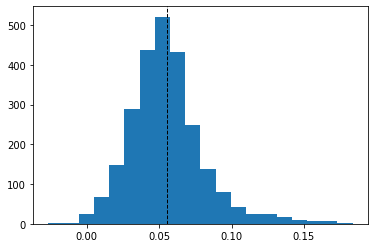

In [22]:
plt.hist(point, bins=20)
plt.axvline(point.mean(), color='k', linestyle='dashed', linewidth=1)

In [23]:
pd.Series(causal_forest.feature_importances(), index=covariates).sort_values()

MUN2                     0.000000
MUN3                     0.000000
s3aelectric_hh_05        0.000215
MUN6                     0.000545
MUN1                     0.000800
MUN4                     0.000913
s4p7_parasite_i_06       0.001337
s11ownland_hh_05         0.001661
s1male_head_05           0.001732
s3awater_access_hh_05    0.002053
s1hhsz_25_64_05          0.002524
s3atoilet_hh_05          0.002583
s3ap5_rooms_h_05         0.002760
s1hhsz_65plus_05         0.002900
MUN5                     0.003111
vitamiron_06             0.003227
s1hhsz_5_14_05           0.004881
s4p7_parasite_i_05       0.005085
s1hhsz_undr5_05          0.005731
male                     0.005873
s1hhsize_05              0.008693
s1hhsz_15_24_05          0.009466
s4p6_vitamina_i_05       0.010569
s3ap23_stime_h_05        0.013265
yrsedfath                0.014889
s3ap25_hqtime_h_05       0.019664
ed_mom                   0.022800
s2mother_inhs_05         0.022826
prfruitveg_f_05          0.023508
s1age_head_05 

In [24]:
a=causal_forest.predict_tree_average(X)

In [25]:
np.mean(a)

In [26]:
import sklearn
from sklearn.tree import DecisionTreeRegressor
reg = DecisionTreeRegressor(max_depth=3).fit(X,a)
sklearn.tree.export_graphviz(reg, 'test.dot')

In [29]:
import graphviz
import os 
os.environ["PATH"] += os.pathsep + 'C:\Program Files\Graphviz/bin/'
# DOT data
dot_data = sklearn.tree.export_graphviz(reg, out_file=None, 
                                feature_names=covariates) 
                                
graph = graphviz.Source(dot_data, format="pdf") 
graph.render("jaimie", format="pdf", view=False)

'jaimie.pdf'

### SHAP

In [30]:
from CTL.causal_tree_learn import CausalTree

In [52]:
cthl = CausalTree(honest=True)
cthl.fit(X.values , Y.values, T.values)
cthl.prune()
cthl_predict = cthl.predict(X_test)

TypeError: '(0, slice(None, None, None))' is an invalid key

In [48]:
X

,s1age_head_05,s1hhsize_05,s1hhsz_undr5_05,s1hhsz_5_14_05,s1hhsz_15_24_05,s1hhsz_25_64_05,s1hhsz_65plus_05,s1male_head_05,s2mother_inhs_05,s3ap5_rooms_h_05,...,MUN6,com_haz_05,com_waz_05,com_vit_05,com_deworm_05,vitamiron_06,propfood_05,prstap_f_05,pranimalprot_f_05,prfruitveg_f_05
1946,0.1250,5.0,1.0,2.0,0.0,2.0,0.0,1.0,1.0,3.0,...,0.0,0.640373,1.076796,0.289474,0.315789,0.0,0.678396,0.892216,0.022300,0.003717
446,0.0625,5.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,2.0,...,0.0,0.684592,0.712725,0.411111,0.466667,0.0,0.714149,0.451275,0.193343,0.067255
1527,0.3875,10.0,2.0,4.0,2.0,2.0,0.0,1.0,0.0,1.0,...,0.0,0.196258,0.215178,0.875000,0.666667,1.0,0.784472,0.736770,0.129854,0.013863
622,0.2375,7.0,2.0,3.0,0.0,2.0,0.0,1.0,1.0,2.0,...,1.0,-1.228299,-1.210792,0.914894,0.744681,1.0,0.850021,0.791775,0.106366,0.023437
1286,0.2625,6.0,1.0,2.0,2.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.534559,0.441283,0.632653,0.408163,0.0,0.472730,0.890088,0.020850,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2976,0.2375,5.0,1.0,2.0,0.0,2.0,0.0,1.0,1.0,1.0,...,0.0,0.028349,-0.644528,0.875000,0.708333,0.0,0.529142,0.886896,0.000000,0.000000
3368,0.4250,8.0,2.0,4.0,0.0,2.0,0.0,1.0,1.0,1.0,...,1.0,0.253803,0.498850,0.705882,0.490196,1.0,0.799101,0.614589,0.035841,0.000000
210,0.2125,3.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,1.0,...,0.0,1.902253,1.908110,0.928571,0.571429,1.0,0.468528,0.466293,0.356353,0.062892
2932,0.5625,4.0,1.0,0.0,1.0,2.0,0.0,0.0,1.0,1.0,...,0.0,-0.536521,-0.231580,0.800000,0.666667,1.0,0.591883,0.669509,0.022622,0.073521


In [49]:
Y

1946    0.739237
446     0.528854
1527    0.003046
622    -0.546806
1286    0.448297
          ...   
2976   -0.331211
3368   -0.536421
210    -0.526686
2932    0.971442
1184    0.853851
Name: z_all_06, Length: 2528, dtype: float32